[Kaggle Tabluar Playground Series Feb 2021](https://www.kaggle.com/c/tabular-playground-series-feb-2021/overview)  

For this competition, you will be predicting a continuous target based on a number of feature columns given in the data. All of the feature columns, cat0 - cat9 are categorical, and the feature columns cont0 - cont13 are continuous.

This model yielded the below score on kaggle:
<img src='v2 score.png'>

## Table of Contents  

* [Import Libraries](#import_libraries)
* [Import Data](#import_data)
* [Create DataFrame and Descriptive Metrics](#create_dataframe)
* [Data Preprocessing; check for nulls](#data_preprocessing)
* [Exploratory Data Analysis](#explore_data)
* [Converting Categorical Features](#convert_categorical)
* [Oberservations & Feature Selection](#obs_feature_select)
* [Standardize Data](#stadardize_data)
* [Splitting the data into training and testing sets](#split_data)  
XGBoost
* [Restructure data into DMatrix](#DMatrix)
* [Create and Train the Model](#train_model)
* [Evaluation Metrics](#eval_metrics)
* [Predictions from our Model](#predict)
* [GridSearchCV](#grid_search)
* [Predictions for Competition](#comp_pred)

<a class="anchor" id="import_libraries"></a>
## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
%matplotlib inline

<a class="anchor" id="import_data"></a>
## Import Data

TRAINING DATA

In [2]:
df = pd.read_csv('train.csv',index_col='id')

In [3]:
df.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,...,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903,6.994023
2,B,A,A,A,B,B,A,E,A,F,...,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464,8.071256
3,A,A,A,C,B,D,A,B,C,N,...,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352,5.760456
4,A,A,A,C,B,D,A,E,G,K,...,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766,7.806457
6,A,B,A,A,B,B,A,E,C,F,...,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743,6.868974


TEST DATA

In [4]:
#import competition feature test set
test = pd.read_csv('test.csv', index_col='id')

<a class="anchor" id="create_dataframe"></a>
## Create DataFrame and Descriptive Metrics

In [37]:
train=df.drop(['target'],axis=1)

In [6]:
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,A,B,D,A,E,C,I,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
2,B,A,A,A,B,B,A,E,A,F,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
3,A,A,A,C,B,D,A,B,C,N,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
4,A,A,A,C,B,D,A,E,G,K,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
6,A,B,A,A,B,B,A,E,C,F,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


In [38]:
train_labels=df['target']

In [8]:
train_labels.head()

id
1    6.994023
2    8.071256
3    5.760456
4    7.806457
6    6.868974
Name: target, dtype: float64

In [21]:
#train.info()

In [26]:
#train.describe()

<a class="anchor" id="data_preprocessing"></a>
## Data Preprocessing; check for nulls  

In [9]:
train.isnull().sum()

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
dtype: int64

In [10]:
test.isnull().sum()

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
dtype: int64

<a class="anchor" id="explore_data"></a>
## Exploratory Data Analysis

<a class="anchor" id="convert_categorical"></a>
## Converting Categorical Features
Convert categorical features to dummy variables

Identify categorigal features and check cardinality

In [13]:
#Create array of only categorical (!= 'object') data types
all_cat_feats = train.columns[train.dtypes == "object"].values
print(all_cat_feats)

['cat0' 'cat1' 'cat2' 'cat3' 'cat4' 'cat5' 'cat6' 'cat7' 'cat8' 'cat9']


**COMPARE CARDINALITY OF TRAIN AND TEST DATASETS**

In [99]:
#check cardinality of training features
#for i in all_cat_feats:
#    print(i, train[i].nunique(), test_values[i].nunique() )

In [14]:
#RETURN FEATURES WHEN CARDINATLITY DOES NOT MATCH B/W TRAIN & TEST DATA
for i in all_cat_feats:
    if train[i].nunique() != test[i].nunique():
        print(i)

cat6


**CARDINALITY DOES NOT MATCH; WE'LL COMBINE TRAIN & TEST DATA SETS PRIOR TO CONVERTING CATEGORICAL FEATURES, THEN SPLIT BACK OUT**

ADD A COLUMN TO BOTH DATASETS TO ID WHICH DATASET IT IS (1=TRAIN, 0 = TEST); WE'LL LATER USE THIS TO ID AND SPLIT DATASETS BACK OUT

In [60]:
train['train']=1
test['train']=0

COMBINE THE TRAIN & TEST DATASETS

In [61]:
combined = pd.concat([train,test])

In [63]:
#combined.info()

ENCODE THE DESIRED FEATURE(S)

In [64]:
#create list of feature to encode
onehot_columns = all_cat_feats
#onehot_columns

In [65]:
#create dataframe of features to encode
onehot_df = combined[onehot_columns]

In [66]:
#When converting binary categorical features with pd.get_dummies, to avoid multicoliniarity need to drop column(s) before fitting model, 
onehot_df = pd.get_dummies(onehot_df, columns = onehot_columns,drop_first=True)

DROP ORIGINALS FROM THE DATAFRAME

In [68]:
#drop the original features from the dataframe
combined_onehot_drop = combined.drop(onehot_columns, axis = 1)

In [73]:
#combined_onehot_drop.info()
#onehot_df

ADD THE NEW ENCODED FEATURES WITH THE 'COMBINED' DATASET

In [74]:
#Add back in the dummy variable features
combined_onehot = pd.concat([combined_onehot_drop, onehot_df], axis = 1)

SPLIT BACK INTO SEPARATE TRAIN & TEST DATASETS

In [80]:
#split based on the 'train' column we created above to differentiate the datasets
train_df = combined_onehot[combined_onehot['train']==1]
test_df = combined_onehot[combined_onehot['train']==0]

#drop the 'train' id column
train_df.drop(['train'],axis=1,inplace=True)
test_df.drop(['train'],axis=1,inplace=True)

c:\users\devin\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


CHECK SHAPE OF DATASETS

In [81]:
train_df.shape

(300000, 60)

In [82]:
test_df.shape

(200000, 60)

In [83]:
train_df.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
1,0.923191,0.684968,0.124454,0.217886,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,...,0,0,0,1,0,0,0,0,0,0
2,0.437627,0.014213,0.357438,0.846127,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,...,1,0,0,0,0,0,0,0,0,0
3,0.732209,0.760122,0.454644,0.812990,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,...,0,0,0,0,0,0,0,0,1,0
4,0.705142,0.771678,0.153735,0.732893,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,...,0,0,0,0,0,1,0,0,0,0
6,0.486063,0.639349,0.496212,0.354186,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,...,1,0,0,0,0,0,0,0,0,0


<a class="anchor" id="stadardize_data"></a>
## Standardize Data

In [84]:
from sklearn import preprocessing

In [85]:
scaler = preprocessing.StandardScaler()

In [86]:
scaler.fit(train_df)

StandardScaler()

In [87]:
X_scaled = scaler.transform(train_df)

In [88]:
type(X_scaled)

numpy.ndarray

In [89]:
#Converting numpy array to dataframe
X_scaled_df = pd.DataFrame(X_scaled, index=train_df.index, columns=train_df.columns) 

In [90]:
X_scaled_df.head()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,...,cat9_F,cat9_G,cat9_H,cat9_I,cat9_J,cat9_K,cat9_L,cat9_M,cat9_N,cat9_O
id,,,,,,,,,,,,,,,,,,,,,
1,1.945372,0.757938,-1.597601,-0.956673,-0.867238,1.609527,-0.294623,1.396184,1.978227,1.350628,...,-0.746104,-0.189588,-0.299923,2.234352,-0.154352,-0.274035,-0.40459,-0.184134,-0.117886,-0.144945
2,-0.424682,-2.093075,-0.433193,1.675598,-0.862591,-0.295002,-0.686557,-0.867560,0.607739,0.093896,...,1.340296,-0.189588,-0.299923,-0.447557,-0.154352,-0.274035,-0.40459,-0.184134,-0.117886,-0.144945
3,1.013181,1.077375,0.052623,1.536759,-0.805777,1.752148,-0.565102,1.841928,1.841445,1.462334,...,-0.746104,-0.189588,-0.299923,-0.447557,-0.154352,-0.274035,-0.40459,-0.184134,8.482759,-0.144945
4,0.881067,1.126494,-1.451257,1.201160,1.566127,1.838425,0.522703,-0.237621,1.852684,1.311128,...,-0.746104,-0.189588,-0.299923,-0.447557,-0.154352,3.649163,-0.40459,-0.184134,-0.117886,-0.144945
6,-0.188265,0.564033,0.260374,-0.385590,-0.878778,-0.542878,1.182729,-0.639198,-0.083184,-0.317379,...,1.340296,-0.189588,-0.299923,-0.447557,-0.154352,-0.274035,-0.40459,-0.184134,-0.117886,-0.144945


<a class="anchor" id="split_data"></a>
## Splitting the data into training and testing sets

In [91]:
from sklearn.model_selection import train_test_split

In [92]:
X = X_scaled_df
y = train_labels

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

<a class="anchor" id="DMatrix"></a>
## Restructure data into DMatrix

In [96]:
#X_train.columns

In [95]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

<a class="anchor" id="train_model"></a>
## Create and Train the Model

Instantiate Model

In [133]:
xgb_r = xgb.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)

In [134]:
# Fitting the model 
xgb_r.fit(X_train, y_train) 

[12:22:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=4, num_parallel_tree=1,
             objective='reg:linear', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<a class="anchor" id="eval_metrics"></a>
## Evaluation Metrics

In [113]:
from sklearn import metrics 

In [135]:
# Predict the model 
predictions = xgb_r.predict(X_test) 

In [136]:
# RMSE Computation 
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.7341425891781179
MSE: 0.7713166950360943
RMSE: 0.8782463749063211


<a class="anchor" id="predict"></a>
## Predictions from our Model

In [153]:
#pass in data the model hasn't seen before (feature data set of our test data)
#predictions = xgb_r.predict(X_test) 

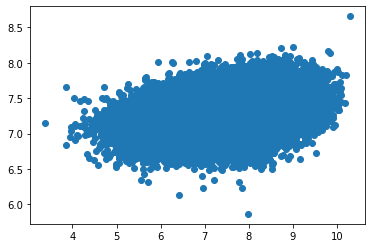

In [125]:
#compare predictions agains actual labels using a scatter plot, the more linear = the more accurate/correct predictions
plt.scatter(y_test,predictions)

**Residual Histogram**

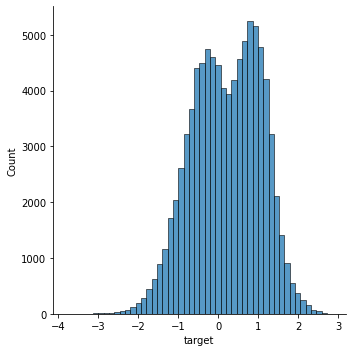

In [126]:
#create a histogram of the residuals (difference/error b/w actuals and predictions )

#if residuals are normally distributed (or approximate), then the model was the correct choice for the data; if not consider a different type of model
sns.displot((y_test-predictions),bins=50);

<a class="anchor" id="grid_search"></a>
## GridSearchCV

Reference the offical documentation here [XGBoost Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html)

   **eta**: (aka 'learning rate') gives us a chance to prevent overfitting by reducing the weight of the predictions of the new 
    trees; eta will be multiplied by the residuals being adding to reduce their weight; this effectively reduces the complexity 
    of the overall model.  
    **max_depth**: maximum depth of the decision trees being trained  
    **objective**: the loss function being used  
    **num_class**: the number of classes in the dataset 

In [140]:
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBRegressor

#create instance of model to use
clf = xgb.XGBRegressor()

#define parameters to test
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

#instantiate GridSearchCV with the model and parameters
xgb_grid = GridSearchCV(clf,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [142]:
#fit the estimator to the training data
xgb_grid.fit(X_train, y_train)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[13:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[13:04:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             n_

In [143]:
#Inspect the best score;
print(xgb_grid.best_score_)

#Inspect the best parameters; best_params_  attribute:
print(xgb_grid.best_params_)

0.0890466768381894
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


<a class="anchor" id="gs_predict"></a>
## Predictions from GridSearchCV Model

In [144]:
grid_predictions = xgb_grid.predict(X_test)

In [145]:
# RMSE Computation 
print('using initial Parameters:')
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

using initial Parameters:
MAE: 0.7341425891781179
MSE: 0.7713166950360943
RMSE: 0.8782463749063211


In [146]:
# RMSE Computation 
print('using GridSearchCV Parameters:')
print('MAE:', metrics.mean_absolute_error(y_test, grid_predictions))
print('MSE:', metrics.mean_squared_error(y_test, grid_predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, grid_predictions)))

using GridSearchCV Parameters:
MAE: 0.706179878696388
MSE: 0.7114184222812523
RMSE: 0.843456236138694


<a class="anchor" id="comp_pred"></a>
## Predictions for Competition

Perform same preprocessing steps as on training data

**CONVERT CATEGORICAL**

ALREADY CONVERTED ABOVE, WITH TRAINING DATA

**STANDARDIZE DATA**

In [147]:
#use scaler fitted to the training data
X_scaled_tst = scaler.transform(test_df)
type(X_scaled_tst)

numpy.ndarray

In [149]:
#Converting numpy array to dataframe
X_scaled_tst = pd.DataFrame(X_scaled_tst, index=test_df.index, columns=test_df.columns) 

**Restructure data into DMatrix**

In [ ]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

**MAKE PREDICTIONS WITH TEST DATA**

In [150]:
predict = xgb_grid.predict(X_scaled_tst)

In [151]:
np.array(predict).shape

(200000,)

In [152]:
predict

array([7.545695 , 7.853154 , 7.597432 , ..., 7.462905 , 7.427323 ,
       7.3452034], dtype=float32)

**CREATE DATAFRAME OF PREDICTIONS, WITH INDEX**

In [153]:
#name column(s) as desired
final_dataset = pd.DataFrame(
    {
        "target": predict[:],
    },
    index = test_df.index
)

In [154]:
final_dataset.shape

(200000, 1)

In [155]:
final_dataset.head()

,target
id,
0,7.545695
5,7.853154
15,7.597432
16,7.450446
17,7.317441


**CREATE SUBMISSION FILE**

Import the provided sample_submission.csv to use as a template to create your submission file:

In [156]:
submission_format = pd.read_csv('sample_submission.csv', index_col='id')

In [157]:
submission_format.columns

Index(['target'], dtype='object')

In [158]:
my_submission = pd.DataFrame(data=final_dataset,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [159]:
my_submission.head()

,target
id,
0,7.545695
5,7.853154
15,7.597432
16,7.450446
17,7.317441


In [160]:
my_submission.to_csv('v2 xgb.csv')